In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("/content/drive/MyDrive/resale_flat_prices.csv")

In [7]:
def data_prep(df):
    """
    1. Dummy variables for
        a. Town
        b. Flat Type
        c. Flat Storey
        d. Flat Model
    
    2. Integer Encoding for Flat Storey (for trees)
        
    """
    dummy = pd.get_dummies(df[['town', 'flat_type', 'flat_model']])
    df = pd.concat([df, dummy], axis=1)
   
    storey_range_map = {
        '01 TO 03': 1,
        '04 TO 06': 2,
        '07 TO 09': 3,
        '10 TO 12': 4,
        '13 TO 15': 5,
        '16 TO 18': 6,
        '19 TO 21': 7,
        '22 TO 24': 8,
        '25 TO 27': 9,
        '28 TO 30': 10,
        '31 TO 33': 11, 
        '34 TO 36': 12,
        '37 TO 39': 13,
        '40 TO 42': 14,
        '43 TO 45': 15,
        '46 TO 48': 16,
        '49 TO 51': 17
    }

    df['storey_range_cat'] = df['storey_range'].transform(lambda x: storey_range_map[x])
    
    return df

In [8]:
prep_df = data_prep(df)

(array([9.77228141e-09, 2.35232774e-07, 1.06657471e-06, 1.93002558e-06,
        2.63735261e-06, 2.83419428e-06, 2.83512498e-06, 3.04709041e-06,
        2.59803082e-06, 1.72620371e-06, 1.54960462e-06, 1.17104506e-06,
        9.53960805e-07, 7.01975548e-07, 6.25891357e-07, 5.80985397e-07,
        3.73673427e-07, 3.51569457e-07, 2.55475357e-07, 1.66594131e-07,
        1.10519849e-07, 8.95792463e-08, 4.70000201e-08, 3.11782312e-08,
        1.97772362e-08, 9.30693468e-09, 6.51485427e-09, 5.58416081e-09,
        3.02475377e-09, 1.16336683e-09]),
 array([ 140000.,  178500.,  217000.,  255500.,  294000.,  332500.,
         371000.,  409500.,  448000.,  486500.,  525000.,  563500.,
         602000.,  640500.,  679000.,  717500.,  756000.,  794500.,
         833000.,  871500.,  910000.,  948500.,  987000., 1025500.,
        1064000., 1102500., 1141000., 1179500., 1218000., 1256500.,
        1295000.]),
 <a list of 30 Patch objects>)

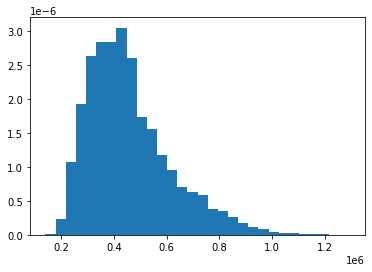

In [ ]:
# histogram of target, need to do log transformation 

plt.hist(prep_df["resale_price"], density=True, bins=30)

In [9]:
#remove non-x columns
remove_columns = ["month", "block", "street_name", "town", "flat_type", "storey_range", "flat_model", "remaining_lease", "resale_price"]
x_columns = list(prep_df.columns)

for i in remove_columns:
    x_columns.remove(i)

In [10]:
df_X = prep_df[x_columns]

# do log transformation of target
df_y = np.log(prep_df["resale_price"])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.3,
                                                    random_state = 0)

df_train = pd.concat([X_train, y_train], axis = 1).reset_index()
df_test = pd.concat([X_test, y_test], axis = 1).reset_index()

In [ ]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(78143, 56) (78143,)
(33490, 56) (33490,)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_X
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                              feature        VIF
0                      floor_area_sqm  20.398820
1                 lease_commence_date   3.329430
2                     town_ANG MO KIO        inf
3                          town_BEDOK        inf
4                         town_BISHAN        inf
5                    town_BUKIT BATOK        inf
6                    town_BUKIT MERAH        inf
7                  town_BUKIT PANJANG        inf
8                    town_BUKIT TIMAH        inf
9                   town_CENTRAL AREA        inf
10                 town_CHOA CHU KANG        inf
11                      town_CLEMENTI        inf
12                       town_GEYLANG        inf
13                       town_HOUGANG        inf
14                   town_JURONG EAST        inf
15                   town_JURONG WEST        inf
16               town_KALLANG/WHAMPOA        inf
17                 town_MARINE PARADE        inf
18                     town_PASIR RIS        inf
19                  

Linear Regression

In [ ]:
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='neg_root_mean_squared_error')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [ ]:
def get_lr(X, y): 
    
    lr = LinearRegression().fit(X, y)

    return get_cv_scores(lr)

In [ ]:
get_lr(X_train,y_train)

CV Mean:  -0.1152552666612348
STD:  0.00060059258178394




In [12]:
def get_lr_ridge(X, y): 
    
    ridge = Ridge(alpha=1).fit(X_train, y_train)
    
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    
    grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1,cv=5)
    grid_result = grid.fit(X, y)
    
    
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)

In [ ]:
get_lr_ridge(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score:  -0.11525509191827008
Best Params:  {'alpha': 0.1}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.9s finished


In [13]:
 def get_lr_ridge_plot(X, y): 
    
    alpha_space = np.logspace(-8, 8, 100)
    ridge_scores = []
    ridge_scores_std = []

    # Create a ridge regressor: ridge
    ridge = Ridge(normalize=False, fit_intercept=False)

    # Compute scores over range of alphas
    for alpha in alpha_space:

        # Specify the alpha value to use: ridge.alpha
        ridge.alpha = alpha
        
        # Perform 5-fold CV: ridge_cv_scores
        ridge_cv_scores = cross_val_score(ridge, X, y, cv=5, scoring= "neg_mean_squared_error")
        
        # Append the mean of ridge_cv_scores to ridge_scores
        ridge_scores.append(np.mean(ridge_cv_scores))
        
        # Append the std of ridge_cv_scores to ridge_scores_std
        ridge_scores_std.append(np.std(ridge_cv_scores))


    def display_plot(cv_scores, cv_scores_std):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(alpha_space, cv_scores)

        std_error = cv_scores_std / np.sqrt(10)
        ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
        ax.set_ylabel('Neg Mean Square Error')
        ax.set_xlabel('Alpha')
        ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
        ax.set_xlim([alpha_space[0], alpha_space[-1]])
        ax.set_xscale('log')
        plt.show()


    display_plot(ridge_scores, ridge_scores_std)

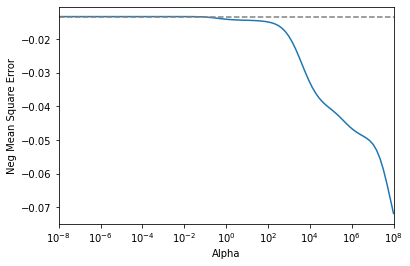

In [14]:
get_lr_ridge_plot(X_train, y_train)

In [ ]:
def get_lr_lasso(X, y): 
    
    lasso = Lasso(alpha=1).fit(X_train, y_train)
    
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    
    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1,cv=5)
    grid_result = grid.fit(X, y)
    
    
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
    coef = grid_result.best_estimator_.coef_
    col = list(X.columns)
    coefficient_df = pd.DataFrame({"Variable" : col, "Coefficient": coef})
    coefficient_df = coefficient_df.sort_values(['Coefficient'],ascending=False)
    print(coefficient_df)

In [ ]:
get_lr_lasso(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.4s finished


Best Score:  -0.12412187593698684
Best Params:  {'alpha': 0.001}
                             Variable  Coefficient
20                    town_QUEENSTOWN     0.225861
9                   town_CENTRAL AREA     0.215424
6                    town_BUKIT MERAH     0.213976
17                 town_MARINE PARADE     0.190012
4                         town_BISHAN     0.168373
38                    flat_model_DBSS     0.146255
16               town_KALLANG/WHAMPOA     0.121742
11                      town_CLEMENTI     0.071520
25                     town_TOA PAYOH     0.065271
12                       town_GEYLANG     0.065016
31                   flat_type_4 ROOM     0.029739
55                   storey_range_cat     0.028396
8                    town_BUKIT TIMAH     0.027159
1                 lease_commence_date     0.009862
0                      floor_area_sqm     0.009695
41              flat_model_Maisonette     0.008449
23                     town_SERANGOON     0.003876
2                

In [ ]:
def get_lr_lasso_plot(X, y): 
    
    alpha_space = np.logspace(-8, 8, 100)
    lasso_scores = []
    lasso_scores_std = []

    # Create a lasso regressor: lasso
    lasso = Lasso(normalize=False, fit_intercept=False)

    # Compute scores over range of alphas
    for alpha in alpha_space:

        # Specify the alpha value to use: lasso.alpha
        lasso.alpha = alpha
        
        # Perform 5-fold CV: lasso_cv_scores
        lasso_cv_scores = cross_val_score(lasso, X, y, cv=5, scoring= "neg_mean_squared_error")
        
        # Append the mean of lasso_cv_scores to lasso_scores
        lasso_scores.append(np.mean(lasso_cv_scores))
        
        # Append the std of lasso_cv_scores to lasso_scores_std
        lasso_scores_std.append(np.std(lasso_cv_scores))


    def display_plot(cv_scores, cv_scores_std):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(alpha_space, cv_scores)

        std_error = cv_scores_std / np.sqrt(10)
        
        ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
        ax.set_ylabel('Neg Mean Square Error')
        ax.set_xlabel('Alpha')
        ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
        ax.set_xlim([alpha_space[0], alpha_space[-1]])
        ax.set_xscale('log')
        plt.show()


    display_plot(lasso_scores, lasso_scores_std)

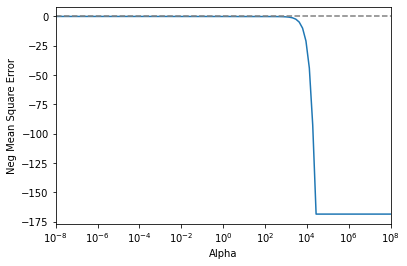

In [19]:
get_lr_lasso_plot(X_train, y_train)

Decision Tree

In [ ]:
def get_dt_reg(X, y): 
    
    param_grid = {"max_depth": [2,3,4,5,6], 
                  'max_features': ['sqrt', 'log2'],
                "min_samples_leaf": [0.01,0.02,0.04,0.06,0.08]
                  }
    
    dt_gs = GridSearchCV(estimator = DecisionTreeRegressor(), 
                               param_grid = param_grid,
                               cv = 5,
                         scoring = 'neg_root_mean_squared_error')
    dt_gs.fit(X, y)

    dt = dt_gs.best_estimator_ 
    
    return dt_gs, dt

In [ ]:
dt_gs, dt = get_dt_reg(X_train, y_train)

In [ ]:
dt_gs.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.01}

In [ ]:
dt_gs.best_score_

-0.2293131015731019

In [ ]:
#importance graph function for trees
def importance_graph(model):
    # Create a pd.Series of features importances
    importances = pd.Series(data=model.feature_importances_,
                            index= list(X_train.columns))

    # Sort importances
    importances_sorted = importances.sort_values()
    
    # Limit top 10
    importances_sorted = importances_sorted[-10:]

    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Features Importance (Top 10)')
    plt.show()

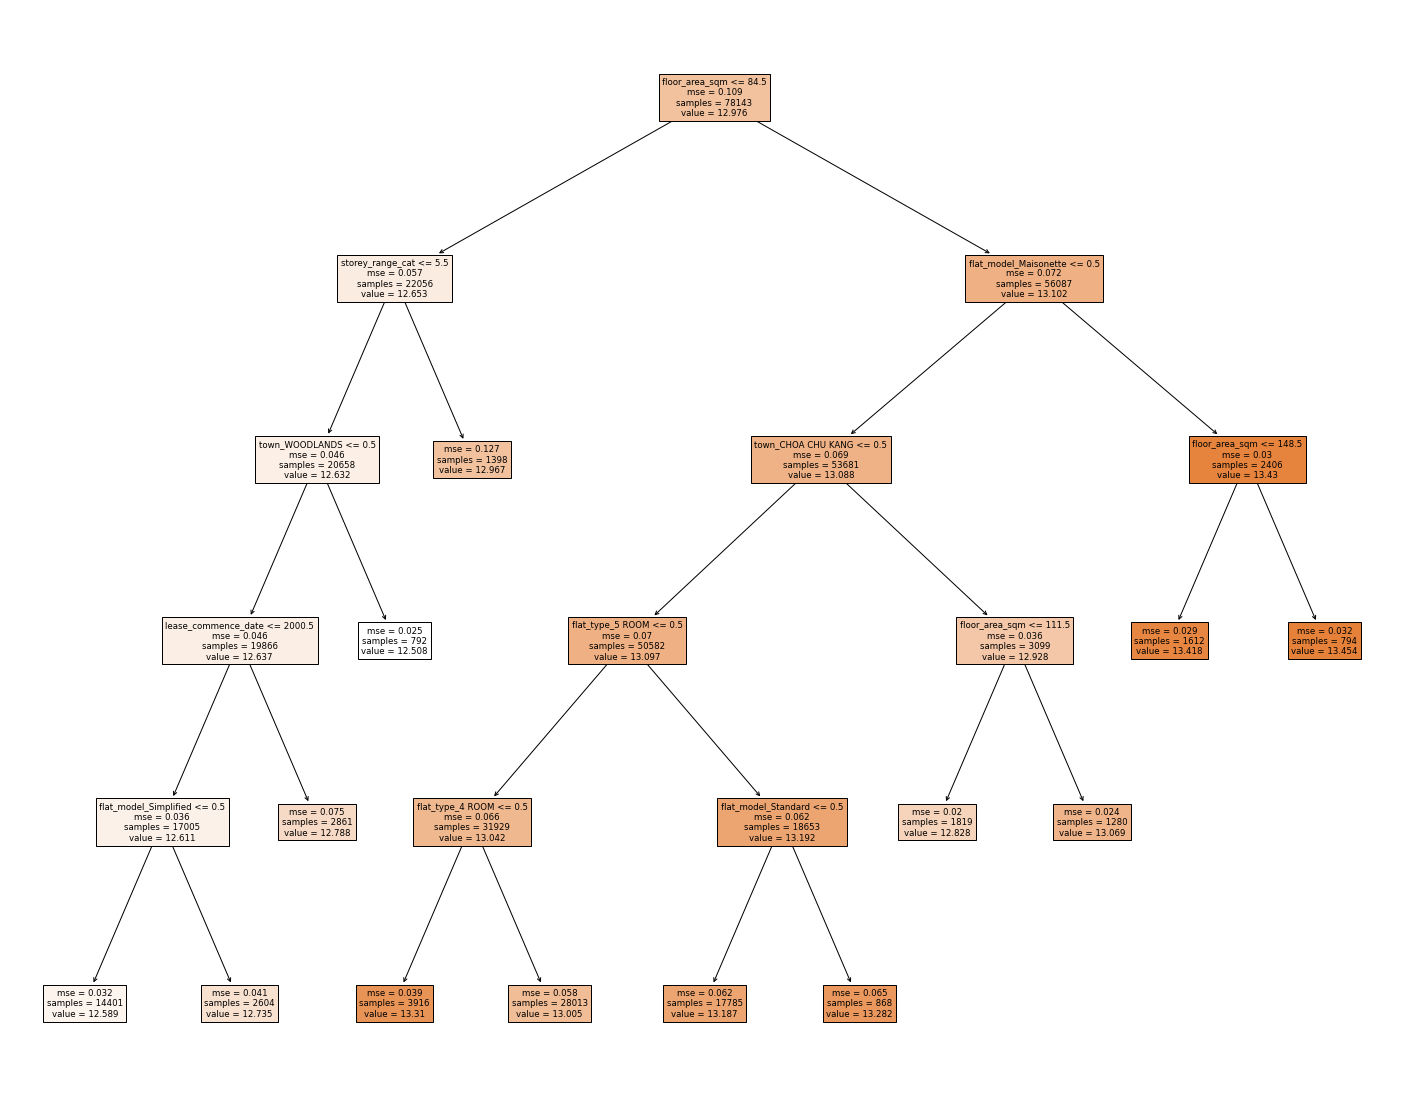

In [ ]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt,
               feature_names = list(X_train.columns), 
               filled = True);

Random Forest

In [ ]:
def get_rf_reg(X, y): 
    
    param_grid = {"max_depth": [2,3,4,5,6], 
                  'max_features': ['sqrt', 'log2'],
                  "min_samples_leaf": [0.01,0.02,0.04,0.06,0.08]
                  }
    
    rf_gs = GridSearchCV(estimator = RandomForestRegressor(), 
                               param_grid = param_grid,
                               cv = 5,
                         scoring = 'neg_root_mean_squared_error')
    rf_gs.fit(X, y)

    rf = rf_gs.best_estimator_
    
    return rf_gs, rf

In [ ]:
rf_gs, rf = get_rf_reg(X_train, y_train)

In [ ]:
rf_gs.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.02}

In [ ]:
rf_gs.best_score_

-0.22993897957441728

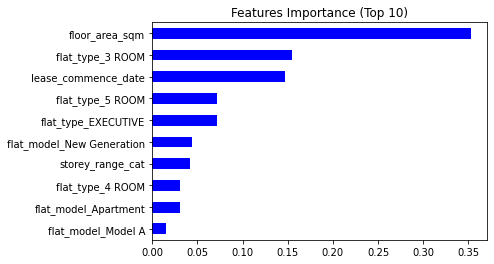

In [ ]:
importance_graph(rf)

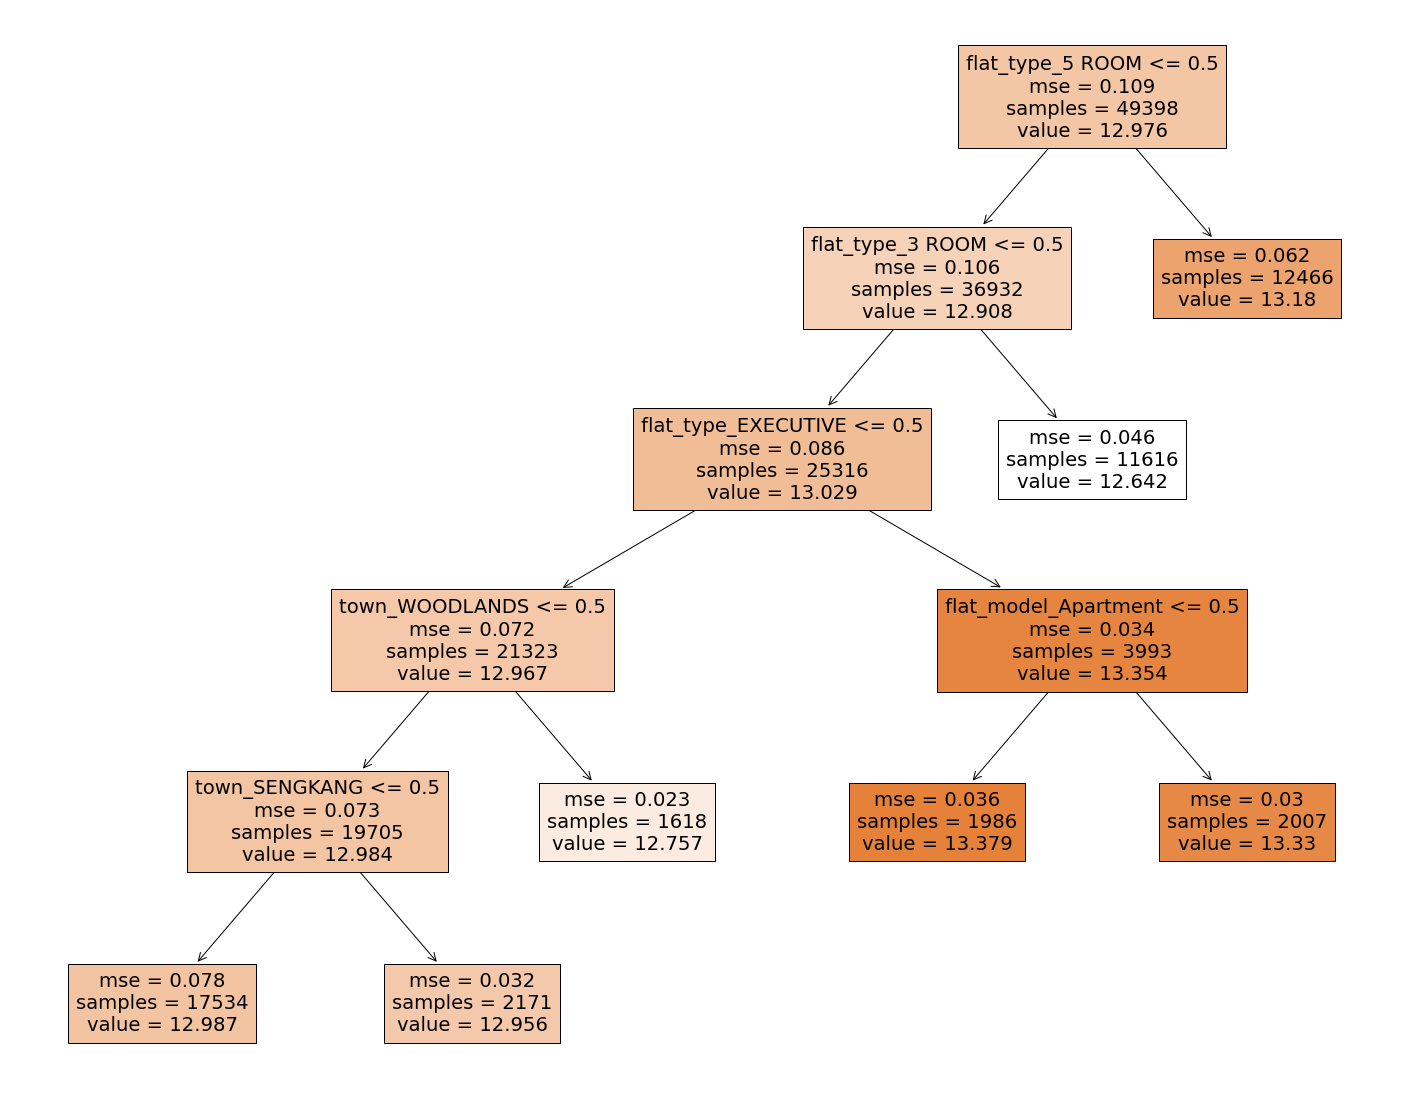

In [ ]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rf.estimators_[0],
               feature_names = list(X_train.columns), 
               filled = True);

Model Evaluation (Ridge)

In [ ]:
def get_lr_ridge_test(X_train, y_train, X_test, y_test): 
    
    ridge = Ridge(alpha=1).fit(X_train, y_train)
    
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    
    grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1,cv=5)
    grid_result = grid.fit(X_test, y_test)
    
    
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
    coef = grid_result.best_estimator_.coef_
    col = list(X_test.columns)
    coefficient_df = pd.DataFrame({"Variable" : col, "Coefficient": coef})
    coefficient_df = coefficient_df.sort_values(['Coefficient'],ascending=False)
    print(coefficient_df)

In [ ]:
get_lr_ridge_test(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score:  -0.11624996055213617
Best Params:  {'alpha': 0.1}
                             Variable  Coefficient
52                 flat_model_Terrace     0.535620
8                    town_BUKIT TIMAH     0.395334
17                 town_MARINE PARADE     0.387141
9                   town_CENTRAL AREA     0.327025
20                    town_QUEENSTOWN     0.265199
6                    town_BUKIT MERAH     0.252678
40     flat_model_Improved-Maisonette     0.251392
4                         town_BISHAN     0.217757
16               town_KALLANG/WHAMPOA     0.153031
32                   flat_type_5 ROOM     0.134597
11                      town_CLEMENTI     0.124740
33                flat_type_EXECUTIVE     0.121316
25                     town_TOA PAYOH     0.120751
12                       town_GEYLANG     0.120316
31                   flat_type_4 ROOM     0.102734
34         flat_type_MULTI-GENERATION     0.078414
45        flat_model_Multi Generation     0.078414
38                 

[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.3s finished


In [15]:
df[df['flat_model'] == 'Terrace']['resale_price'].median()

830000.0

In [16]:
df[df['flat_model'] == 'Standard']['resale_price'].median()

315000.0

In [17]:
df[df['town'] == 'BUKIT TIMAH']['resale_price'].median()

718000.0

In [18]:
df[df['town'] == 'WOODLANDS']['resale_price'].median()

380000.0